# Projet 6 : Catégorisez automatiquement des questions
# <u>B. Topic Modeling</u> <br/>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from bs4 import BeautifulSoup
import unicodedata
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.toktok import ToktokTokenizer
from contractions import CONTRACTION_MAP
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

from sklearn.model_selection import GridSearchCV

from sklearn import model_selection, metrics
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline

# 1. Chargement des données pré-traitées

Nos données sont réparties dans 5 fichiers représentant une taille totale de 0,12Go.

In [2]:
df = pd.read_csv('cleaned_data.csv')
#replace NaN by empty string
df = df.replace(np.nan, '', regex=True)

In [3]:
df.shape

(64432, 7)

In [4]:
df.head()

,TITLE,BODY,SCORE,TAGS,TITLE_P,BODY_P,TAGS_P
0,Java generics variable <T> value,<p>At the moment I am using the following code...,6,<java><generics>,java gener variabl valu,moment use follow code filter jpa valu getclas...,java generics
1,How a value typed variable is copied when it i...,<blockquote>\n <p>Swift's string type is a va...,6,<swift><function><value-type>,valu type variabl copi pass function hold copi,swift string type valu type creat new string v...,swift function value-type
2,Error while waiting for device: The emulator p...,<p>I am a freshman for the development of the ...,6,<android><android-studio><android-emulator><avd>,error wait devic emul process avd kill,freshman develop andriod suffer odd question r...,android android-studio android-emulator avd
3,gulp-inject not working with gulp-watch,<p>I am using gulp-inject to auto add SASS imp...,10,<javascript><node.js><npm><gulp><gulp-watch>,gulp inject work gulp watch,use gulp inject auto add sass import newli cre...,javascript node.js npm gulp gulp-watch
4,React - Call function on props change,<p>My TranslationDetail component is passed an...,12,<reactjs><react-router>,react call function prop chang,translationdetail compon pass id upon open bas...,reactjs react-router


# 2. Transformation des données

## 2.1 Echantillonage

Travaillons sur un échantillon de 15 000 posts.

In [9]:
df_sample = df.sample(15000)

In [10]:
df_sample.shape

(15000, 7)

** Analysons le nombre de mots que contient ce corpus.**

In [11]:
my_counter = Counter()
for sentence in df_sample['TITLE_P']:
    my_counter.update(sentence.split())
for sentence in df_sample['BODY_P']:
    my_counter.update(sentence.split())
words_df = pd.DataFrame.from_dict(my_counter, orient='index')
words_df.reset_index(drop = False, inplace = True)
words_df= words_df.rename(columns={'index':'word', 0:'count'})

In [12]:
words_df.shape[0]

78525

=> Notre corpus est composé de près de **80 000 mots.**

Regardons le nombre de mots qui sont suffisamment fréquents. Ceux qui sont présents dans au minimum 500 documents.

In [16]:
len(words_df[words_df['count'] > 500])

780

environ **780 mots** sont présents dans au moins 500 posts.<br/>
Nous nous baserons sur cette valeur quand nous allons transformer nos données en matrice.

## 2.2 Filtre sur les tags les plus fréquents

Pour chaque tag on stocke son nombre d'occurences.

In [17]:
counts = Counter()
for sentence in df['TAGS_P']:
    counts.update(sentence.split())
tags_df = pd.DataFrame.from_dict(counts, orient='index')
tags_df.reset_index(drop = False, inplace = True)
tags_df= tags_df.rename(columns={'index':'tag', 0:'count'})

La structures tags_df contient pour chacun des tags son occurence. <br/>
Gardons que les tags qui sont présents dans au moins 100 documents.

In [19]:
len(tags_df[tags_df['count'] > 200])

142

Nous nous retrouvons donc avec 142 tags au lieu des 14000 dans le dataset original.

=> Filtrons maintenant notre dataset sample en ne gardant que les posts dont les tags sont les plus fréquents.

In [20]:
frequent_tags = tags_df[tags_df['count'] > 200]['tag'].tolist()

In [21]:
df_sample['TAGS_P'] = df_sample['TAGS_P'].apply(lambda x: ' '.join( [w for w in x.split() if w in frequent_tags] ))
df_sample['TAGS_P'].replace('', np.nan, inplace=True)
df_sample = df_sample.dropna()

In [22]:
df_sample.shape

(13752, 7)

Notre dataset contient maintenant uniquement les posts avec tags fréquents.

## 2.3 Découpage en jeu entrainement et test

In [23]:
X = df_sample[['TITLE', 'BODY','TITLE_P', 'BODY_P']]
Y = df_sample[['TAGS_P']]

In [24]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X,Y,test_size = 0.3,random_state = 0, shuffle = True)

In [25]:
print("train", x_train.shape)
print("test ",x_test.shape)

train (9626, 4)
test  (4126, 4)


On concatène le titre et le body qui ont été pré-traités pour notre apprentissage.

In [26]:
x_train_text = x_train['TITLE_P'] + ' ' + x_train['BODY_P']

## 2.4 Bag of words

Pour pouvoir appliquer nos algorithmes de machine learning à nos données textuelles, il faut en extraire les features et représenter notre texte dans un modèle "mathématique".
Pour celà nous allons utiliser la modélisation **Bag of Words** qui va donner une représentation sous forme de matrice de nos données.

- min_df = 5 : le mot doit être présent au moins dans 5 documents
- max_df = 95% : si le mot est présent dans plus de 95% des documents, il ne nous aidera pas à trouver différencier les documents et on le supprime
- max_features : on se limite à 300 mots maximum (nous avons vu plus haut que 598 mots sont présents au moins dans 500 posts).

In [29]:
cv = CountVectorizer(min_df=5, max_df=0.95, max_features=780)
data_vectorized = cv.fit_transform(x_train_text)
cv_matrix = data_vectorized.toarray()
cv_matrix.shape

(9626, 780)

Voyons à quoi ressemble notre matrice.

In [30]:
#get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab).head()

,abl,accept,access,account,achiev,action,activ,activitythread,actual,ad,...,worker,would,wrap,wrapper,write,wrong,www,xcode,xml,xmln
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Quels sont les mots les plus communs dans nos documents ?

In [31]:
voc_freq_df = pd.DataFrame([list(a) for a in zip(vocab, np.asarray(cv_matrix.sum(axis=0)).ravel())])
voc_freq_df.columns = ['word', 'count']
voc_freq_df.set_index('word', inplace=True)
voc_freq_df=voc_freq_df.sort_values('count', ascending=False)
voc_freq_df.head()

,count
word,
use,14020
android,10184
class,8362
error,7827
file,7646


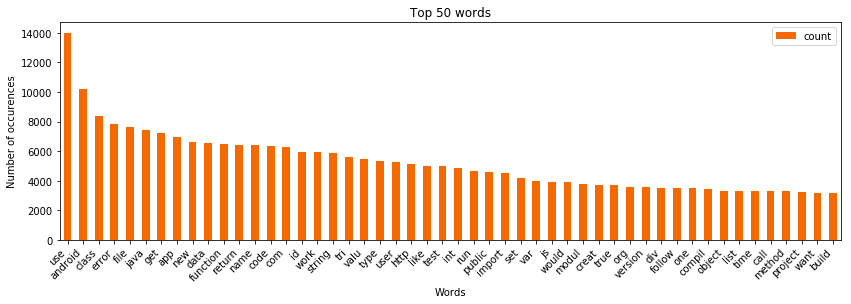

In [32]:
ax = voc_freq_df.head(50).plot(kind = 'bar', figsize = (14,4), color="#f56900")
plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right')
plt.title('Top 50 words', fontsize = 'large')
plt.xlabel('Words')
plt.ylabel('Number of occurences')
plt.show()

use, android, class ... sont très fréquents

####  Sparsicity de la matrice

Regardons le pourcentage de cellules non égales à 0.

In [33]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity:  {:.2f} %".format( ((data_dense > 0).sum()/data_dense.size)*100, "%"))

Sparsicity:  5.26 %


# 3. Modélisation avec méthodes non supervisées

## 3.1 LDA

### Construction du modèle

Nous pouvons partir sur 30 topics.

In [34]:
lda_model = LatentDirichletAllocation(n_components=30, max_iter=10,  learning_method='online',random_state=0)
lda_output = lda_model.fit_transform(cv_matrix)

### Evaluation

Affichage des top words pour chaque topics.

In [35]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

#### Topics / Words

In [36]:
no_top_words = 10
display_topics(lda_model, vocab, no_top_words)

Topic 0:
data valu key map date array row queri select index
Topic 1:
error page respons header get url content request post tri
Topic 2:
id tabl end databas column creat db tag record mysql
Topic 3:
modul import node compon js path rout export app webpack
Topic 4:
angular js script html src http app ts observ css
Topic 5:
product gem lib rubi ptr rail rb block level requir
Topic 6:
php token properti string length byte address charact languag hello
Topic 7:
app log messag io firebas consol devic send notif push
Topic 8:
imag librari packag use version color transform instal locat icon
Topic 9:
var list text function element count bar option font new
Topic 10:
thread task stream spark memori warn process collect async run
Topic 11:
org info spring apach xml http resourc version depend boot
Topic 12:
self python line lib py local usr def file init
Topic 13:
android layout id parent width height app view match widget
Topic 14:
type swift event set param error dev extens sign paramet
Topi

Nous pouvons interpréter certains topics : <br/>
- le sujet 4 : angular web dev
- Le sujet 11 : apache / web server 
- Le sujet 22 : authentification
...

#### Topics / Docs

Voyons maintenant le topic associé à quelques documents.

In [86]:
'''
@H : word_to_topics matrix
@W : topics_to_docs matrix
'''
def display_topics(H, W, feature_names, documents, targets, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print ("Topic %d : " % (topic_idx) + " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print ("Doc",doc_index," Title:", documents.iloc[doc_index].TITLE[0:60],
                   "- Tags:[", targets.iloc[doc_index].TAGS_P,"]")
        print("")

In [87]:
display_topics(lda_model.components_, lda_output, vocab, x_train, y_train, 10, 2)

Topic 0 : data valu key map date array row queri select index
Doc 2154  Title: Conditional matrix adjacency calculation - Tags:[ r ]
Doc 8552  Title: get first and last values in a groupby - Tags:[ python pandas dataframe ]

Topic 1 : error page respons header get url content request post tri
Doc 2053  Title: Set status code on http.ResponseWriter - Tags:[ go ]
Doc 7260  Title: Fetch: reject promise and catch the error if status is not O - Tags:[ javascript redux ]

Topic 2 : id tabl end databas column creat db tag record mysql
Doc 4556  Title: How to import .xls file to .sql with a foreign key - Tags:[ php mysql sql ]
Doc 2894  Title: Update database tables - Tags:[ sql ]

Topic 3 : modul import node compon js path rout export app webpack
Doc 21  Title: Node - was compiled against a different Node.js version usin - Tags:[ node.js ]
Doc 3528  Title: Node v9 + Webpack v4 + extract-text-webpack-plugin = Compile - Tags:[ webpack ]

Topic 4 : angular js script html src http app ts observ c

In [41]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(cv_matrix))

Log Likelihood:  -5281324.75097


### Tuning du modèle

In [44]:
from time import time
t0 = time()
# Define Search Param
search_params = {'n_components': [10, 15, 20, 30, 50 ]}

# Init the Model
lda = LatentDirichletAllocation(learning_method='batch', max_iter=5)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)
print("done in %0.3fs." % (time() - t0))

done in 541.054s.


In [45]:
model.best_params_

{'n_components': 20}

In [95]:
lda_best = LatentDirichletAllocation(**model.best_params_, learning_method='online', max_iter=10)

In [96]:
ldabest_output = lda_best.fit_transform(cv_matrix)

In [100]:
topic_tags = {}
for topic_idx, topic in enumerate(lda_best.components_):
    topic_tags[topic_idx] = []
    for i in (topic.argsort()[:-50 - 1:-1]) :
        word = vocab[i]
        if word in frequent_tags :
            t = topic_tags[topic_idx]
            t.extend([word])
print(topic_tags)

{0: ['angular', 'docker', 'kotlin', 'typescript'], 1: [], 2: ['python', 'scala', 'lambda', 'django', 'linux'], 3: ['android', 'java'], 4: ['java', 'spring', 'maven'], 5: ['tensorflow', 'mysql'], 6: ['git', 'go', 'npm', 'linux'], 7: ['list', 'go', 'sql'], 8: ['html', 'css'], 9: ['function'], 10: ['function', 'json'], 11: ['swift', 'github'], 12: ['list'], 13: ['php'], 14: ['function', 'gcc', 'swift'], 15: ['xcode'], 16: ['json', 'sql'], 17: ['string', 'list'], 18: ['function', 'algorithm'], 19: ['angular', 'webpack', 'html', 'npm', 'css', 'javascript', 'json', 'function', 'github']}


In [98]:
display_topics(lda_best.components_, ldabest_output, vocab, x_train, y_train, 10, 2)

Topic 0 : import compon angular export rout app date router path docker
Doc 7281  Title: What exactly does a selector do in angular 2? - Tags:[ angular ]
Doc 6283  Title: What is $implicit in angular 2? - Tags:[ angular ]

Topic 1 : thread time true task system stream fals code execut result
Doc 9147  Title: Arithmetic with very small numbers in R - Tags:[ r ]
Doc 4105  Title: DateTime.Now retrieval speed - Tags:[ c# .net ]

Topic 2 : self python line lib py import file local def spark
Doc 1322  Title: Not able to import python modules unless root user - Tags:[ python python-2.7 ubuntu ]
Doc 5440  Title: python 2.7 functools_lru_cache does not import although inst - Tags:[ python ]

Topic 3 : android com view layout app support googl java id intent
Doc 5297  Title: Recyclerview covered by BottomNavigationView - Tags:[ android ]
Doc 7912  Title: Wrong behavior SwipeRefreshLayout with CollapsingToolbarLayo - Tags:[ android ]

Topic 4 : java org jar com compil gradl intern spring apach la